In [32]:
from models.gan_model import *
import torch
from torch_geometric.utils import to_dense_adj
from torch_geometric.datasets import TUDataset
from torch.utils.data import TensorDataset, DataLoader
import networkx as nx

In [33]:
root = './enzymes'
name = 'ENZYMES'

# The ENZYMES dataset
pyg_dataset = TUDataset(root, name)

# You will find that there are 600 graphs in this dataset
print(pyg_dataset)

ENZYMES(600)


In [34]:
def fix_size(graph):
    input_tensor = to_dense_adj(graph.edge_index)
    if input_tensor.shape[1] != 42:
        zeros = torch.zeros(1, input_tensor.shape[1], 42 - input_tensor.shape[1])
        tensor = torch.cat([input_tensor, zeros], dim=2)

        zeros = torch.zeros(1, 42 - input_tensor.shape[1], 42)
        tensor = torch.cat([tensor, zeros], dim=1)
        return tensor
    else:
        return input_tensor

In [35]:
graphs_relevance = [g for g in pyg_dataset if g.num_nodes in [38, 40, 42]]
graphs = torch.zeros(71, 1, 42, 42)
for i in range(len(graphs_relevance)):
    graphs[i] = fix_size(graphs_relevance[i])

In [36]:
batch_size = 8
graphs_dataset = TensorDataset(graphs)
graphs_dataloader = DataLoader(graphs_dataset, batch_size)

In [37]:
gan = GraphGAN(num_vertex=42)

In [38]:
def train(model, dataloader, num_epochs=10, print_every=1):
    for epoch in range(num_epochs):
        g_l = 0
        d_l = 0
        for batch in dataloader:
            data = batch[0]
            image_size = data.size(0)

            gl, dl = model.forward(data, image_size)
            g_l += gl
            d_l += dl
        if epoch % print_every == 0:
            print("Epoch: " + str(epoch + 1) + "/" + str(num_epochs)
                  + "\td_loss:" + str(round(d_l / len(dataloader), 4))
                  + "\tg_loss:" + str(round(g_l / len(dataloader), 4))
                  )

In [39]:
train(gan, graphs_dataloader, num_epochs=30, print_every=10)

Epoch: 1/50	d_loss:1.0053	g_loss:2.837
Epoch: 11/50	d_loss:0.1854	g_loss:11.7253
Epoch: 21/50	d_loss:0.0138	g_loss:11.7285
Epoch: 31/50	d_loss:0.018	g_loss:6.6754
Epoch: 41/50	d_loss:0.1926	g_loss:6.8005


In [51]:
res = gan.generate(return_symmetric=True).squeeze().detach().numpy()

In [54]:
G = nx.from_numpy_array(res, create_using=nx.Graph())

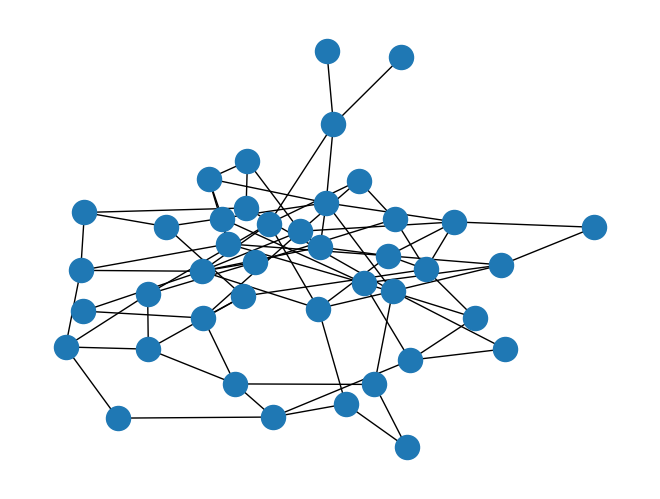

In [55]:
nx.draw(G)